In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from ipywidgets import interactive
import torch
from torchvision import transforms
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 3070 Ti Laptop GPU')

In [3]:
base_path = 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset'

In [4]:
base_path

'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset'

In [5]:
scans = os.path.join(base_path, 'case2', 'case2_day5', 'scans')
contours = os.path.join(base_path, 'case2', 'case2_day5', 'contours','masks_rle.csv')

In [6]:
scans

'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case2\\case2_day5\\scans'

In [7]:
# hand coded color scheme for visualization (order RGB)
default_color_dict = {0 : (255/255., 102/255., 102/255.), #'ampulla_of_vater'
                      1 : (255/255., 178/255., 102/255.), #'large_bowel'
                      2 : (102/255., 255/255., 102/255.), #'pyloric_sphincter'
                      3 : (102/255., 255/255., 255/255.), #'small_bowel'
                      4 : (178/255., 102/255., 255/255.)} #'stomach'
# reference dict for mask type
mask_dict = {0 : 'ampulla of vater',
             1 : 'large bowel',
             2 : 'pyloric sphincter',
             3 : 'small bowel',
             4 : 'stomach'}

In [8]:
def process_image(img):
    gamma = 0.6
    img = img.astype(np.float32)
    img = img ** gamma
    if np.max(img) == 0:
        return np.zeros_like(img)
    else:
        img = img / np.max(img)
    return img

In [9]:
def rle_decode(mask_rle, shape, dtype=np.uint8):
    '''
    Helper function for run-length decoding
    ref.: https://www.kaggle.com/stainsby/fast-tested-rle
    Inputs:
        mask_rle: string formated RLE
        shape: (height,width) of array to return
        dtype: data type of array to return (default: uint8)
    Returns
        numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=dtype)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [10]:
samples = []
for root, dirs, files in os.walk(base_path):
    if 'contours' in root:
       samples.append(os.path.dirname(root))

In [11]:
len(samples)

467

In [12]:
col = []
for sample in samples:
    for root, dir, files in os.walk(sample):
        if 'scans' in root:
            if len(files) == 80:
                samples.remove(sample)

In [13]:
col = []
for sample in samples:
    for root, dir, files in os.walk(sample):
        if 'scans' in root:
            if len(files) == 80:
                print(root)
                samples.remove(sample)

C:\Users\rohit\.cache\kagglehub\datasets\happyharrycn\uw-madison-gi-tract-image-segmentation-dataset\versions\1\dataset\case117\case117_day15\scans
C:\Users\rohit\.cache\kagglehub\datasets\happyharrycn\uw-madison-gi-tract-image-segmentation-dataset\versions\1\dataset\case146\case146_day26\scans
C:\Users\rohit\.cache\kagglehub\datasets\happyharrycn\uw-madison-gi-tract-image-segmentation-dataset\versions\1\dataset\case34\case34_day15\scans
C:\Users\rohit\.cache\kagglehub\datasets\happyharrycn\uw-madison-gi-tract-image-segmentation-dataset\versions\1\dataset\case35\case35_day13\scans


In [14]:
samples

['C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case101\\case101_day20',
 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case101\\case101_day22',
 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case101\\case101_day26',
 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case101\\case101_day32',
 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case102\\case102_day0',
 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case105\\case105_day0',
 'C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happy

In [21]:
for sample in samples:
    for root, dir, files in os.walk(sample):
        if 'scans' in root:
            if len(files) == 80:
                print(root)
                samples.remove(sample)

In [22]:
len(samples)

448

In [23]:
np.unique(np.array(col))

array([], dtype=float64)

In [24]:
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=101)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=101)

In [25]:
len(samples_train), len(samples_test), len(samples_val)

(304, 54, 90)

In [26]:

scans_path = "C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case117\\case117_day15\\scans" 
contours_path = "C:\\Users\\rohit\\.cache\\kagglehub\\datasets\\happyharrycn\\uw-madison-gi-tract-image-segmentation-dataset\\versions\\1\\dataset\\case117\\case117_day15\\contours\\masks_rle.csv"

In [27]:
def load_scans(scans_path, contours_path):
    for root, dir, files in os.walk(scans_path):
        seg_mask = np.zeros((len(files), 256, 256), dtype=np.float32)
        raw_scans = np.zeros((len(files), 256, 256), dtype=np.float32)
        for i, file in enumerate(files): 
            img = cv2.imread(os.path.join(root, file), 0)
            img = process_image(img)
            df = pd.read_csv(contours_path)
            slice_id = file[:10]
            df = df[df['SliceID'] ==  slice_id]
            w, h = df['ImgShape (WxH)'].iloc[0].split()
            h,w = int(w), int(h)
            assert h==img.shape[1] and w==img.shape[0]
            if seg_mask.shape[1]!=w and seg_mask.shape[2]!=h:
                seg_mask = np.zeros((len(files), w, h), dtype=np.float32)
                raw_scans = np.zeros((len(files), w, h), dtype=np.float32)
            dummy_mask = np.zeros((w, h), dtype=np.float32)
            for j in range(len(df)):
                mask_rle = df['EncodedPixels'].iloc[j]
                mask = np.zeros((w, h), dtype=np.float32)
                if mask_rle != -1 and mask_rle != '-1' and mask_rle != '':
                    mask = rle_decode(mask_rle, shape=(w, h),dtype= np.float32)
                # plt.imshow(mask)
                # plt.show()
                dummy_mask[mask==1] = 0
                mask[mask==1] = j+1
                dummy_mask+= mask
            seg_mask[i,:,:] = dummy_mask
            raw_scans[i,:,:] = img
        break
    return raw_scans, seg_mask

In [28]:
raw_scans, seg_mask = load_scans(scans_path, contours_path)

In [29]:
raw_scans.shape

(80, 276, 276)

In [30]:
VOLUME_SLICES = 70
VOLUME_START_AT = 45

In [31]:
IMG_SIZE = 128

class ImageProcessor(Dataset):
    def __init__(self, image_ids, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, shuffle=True):
        self.image_ids = image_ids
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.image_ids)/ self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #batch = 1 means batch_id will have 1 element, batch = 10, batch_ids will have 10 elemets
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.image_ids[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y
    
    def load_scans(self, scans_path, contours_path):
        for root, dir, files in os.walk(scans_path):
            seg_mask = np.zeros((len(files), 256, 256), dtype=np.float32)
            raw_scans = np.zeros((len(files), 256, 256), dtype=np.float32)
            for i, file in enumerate(files): 
                img = cv2.imread(os.path.join(root, file), 0)
                img = process_image(img)
                df = pd.read_csv(contours_path)
                slice_id = file[:10]
                df = df[df['SliceID'] ==  slice_id]
                w, h = df['ImgShape (WxH)'].iloc[0].split()
                h,w = int(w), int(h)
                assert h==img.shape[1] and w==img.shape[0]
                if seg_mask.shape[1]!=w and seg_mask.shape[2]!=h:
                    seg_mask = np.zeros((len(files), w, h), dtype=np.float32)
                    raw_scans = np.zeros((len(files), w, h), dtype=np.float32)
                dummy_mask = np.zeros((w, h), dtype=np.float32)
                for j in range(len(df)):
                    mask_rle = df['EncodedPixels'].iloc[j]
                    mask = np.zeros((w, h), dtype=np.float32)
                    if mask_rle != -1 and mask_rle != '-1' and mask_rle != '':
                        mask = rle_decode(mask_rle, shape=(w, h),dtype= np.float32)
                    # plt.imshow(mask)
                    # plt.show()
                    dummy_mask[mask==1] = 0
                    mask[mask==1] = j+1
                    dummy_mask+= mask
                seg_mask[i,:,:] = dummy_mask
                raw_scans[i,:,:] = img
            break
        return raw_scans, seg_mask
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros(( self.batch_size*VOLUME_SLICES,1, *self.dim))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, patient_path in enumerate(Batch_ids):
            # Get path of each RMI modality and the segmentation
            scans_path = os.path.join(patient_path, 'scans')
            contours_path = os.path.join(patient_path, 'contours','masks_rle.csv')
            # Extract the data from these paths
            raw_scans, seg = self.load_scans(scans_path, contours_path)
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
            
            
        
            for j in range(VOLUME_SLICES):
                #arithmetic series
                X[j +VOLUME_SLICES*c,0,:,:] = cv2.resize(raw_scans[j+VOLUME_START_AT,:,:], (IMG_SIZE, IMG_SIZE))
                if y.shape[1]!=seg.shape[1] and y.shape[2]!=seg.shape[2]:
                    y = np.zeros((self.batch_size*VOLUME_SLICES, *seg.shape[1:]))
                y[j +VOLUME_SLICES*c] = seg[j+VOLUME_START_AT,:,:]
        X_normalized = X/np.max(X)
        X_normalized = torch.FloatTensor(X_normalized)       
        # Masks / Segmentations
        mask = torch.nn.functional.one_hot(torch.LongTensor(y), 6)
        mask = mask.permute(0, 3, 1, 2)
        Y = torch.nn.functional.interpolate(mask.float(), size=(IMG_SIZE, IMG_SIZE), mode='nearest')
        Y =  Y.long().permute(0, 1, 2, 3)
        print(X_normalized.shape, Y.shape)
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X_normalized, Y

In [32]:
training_generator = ImageProcessor(samples_train)
valid_generator = ImageProcessor(samples_val)
test_generator = ImageProcessor(samples_test)

In [33]:
a = training_generator[0][0]

torch.Size([70, 1, 128, 128]) torch.Size([70, 6, 128, 128])


In [34]:
len(training_generator)

304

torch.Size([70, 1, 128, 128]) torch.Size([70, 6, 128, 128])
torch.Size([70, 1, 128, 128]) torch.Size([70, 6, 128, 128])


C:\Users\rohit\AppData\Local\Temp\ipykernel_16576\3593919845.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(training_generator[10][0][50,:,:,0]+training_generator[10][1][50,:,:,0].detach().numpy(), cmap='viridis')


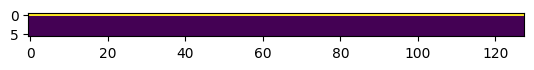

In [35]:
plt.figure()
plt.imshow(training_generator[10][0][50,:,:,0]+training_generator[10][1][50,:,:,0].detach().numpy(), cmap='viridis')

In [32]:
# create a batch of 10

In [74]:
for X_train, y_train in training_generator:
    break

torch.Size([70, 1, 128, 128]) torch.Size([70, 6, 128, 128])


In [91]:
X_train.shape, y_train.shape

(torch.Size([70, 1, 128, 128]), torch.Size([70, 6, 128, 128]))

In [78]:
X_train[0:1,:,:,:].shape

torch.Size([1, 1, 128, 128])

In [85]:
x = X_train[0:1,:,:,:]

In [86]:
# conv layers
conv1 = torch.nn.Conv2d(1, 32, 3, 1,1)
conv2 = torch.nn.Conv2d(32, 32, 3, 1,1)

In [87]:
x = torch.nn.functional.relu(conv1(x))
x = torch.nn.functional.relu(conv2(x))

In [88]:
x.shape

torch.Size([1, 32, 128, 128])

In [89]:
x = torch.nn.functional.max_pool2d(x,2,2)

In [90]:
x.shape

torch.Size([1, 32, 64, 64])

In [ ]:
# Convolution class
class Unet(torch.nn.Module):
    def  __init__(self):
        super().__init__()
        self.conv1_1 = torch.nn.Conv2d(1, 32, 3, 1,1)
        self.conv1_2 = torch.nn.Conv2d(32, 32, 3, 1,1)
        
        self.conv2_1 = torch.nn.Conv2d(32, 64, 3, 1,1)
        self.conv2_2 = torch.nn.Conv2d(64, 64, 3, 1,1)
        
        self.conv3_1 = torch.nn.Conv2d(64, 128, 3, 1,1)
        self.conv3_2 = torch.nn.Conv2d(128, 128, 3, 1,1)
        
        self.conv4_1 = torch.nn.Conv2d(128, 256, 3, 1,1)
        self.conv4_2 = torch.nn.Conv2d(256, 256, 3, 1,1)
        
        self.conv5_1 = torch.nn.Conv2d(256, 512, 3, 1,1)
        self.conv5_2 = torch.nn.Conv2d(512, 512, 3, 1,1)
        
        
        self.upsample_1 = torch.nn.Upsample(scale_factor=2)
        self.conv6_1 = torch.nn.Conv2d(512, 256, 2, 1,1)
        self.conv6_2 = torch.nn.Conv2d(256, 256, 3, 1,1)
        self.conv6_3 = torch.nn.Conv2d(256, 256, 3, 1,1) 
        
        self.upsample_2 = torch.nn.Upsample(scale_factor=2)
        self.conv7_1 = torch.nn.Conv2d(256, 128, 2, 1,1)
        # torch.cat([conv3_2, conv7_1], dim=1) 
        self.conv7_2 = torch.nn.Conv2d(128, 128, 3, 1,1)
        self.conv7_3 = torch.nn.Conv2d(128, 128, 3, 1,1) 
        
        self.upsample_3 = torch.nn.Upsample(scale_factor=2)
        self.conv8_1 = torch.nn.Conv2d(128, 64, 2, 1,1)
        # torch.cat([conv2_2, conv8_1], dim=1) 
        self.conv8_2 = torch.nn.Conv2d(64, 64, 3, 1,1)
        self.conv8_3 = torch.nn.Conv2d(64, 64, 3, 1,1) 
        
        self.upsample_4 = torch.nn.Upsample(scale_factor=2)
        self.conv9_1 = torch.nn.Conv2d(64, 32, 2, 1,1)
        # torch.cat([conv1_2, conv9_1], dim=1) 
        self.conv9_2 = torch.nn.Conv2d(32, 32, 3, 1,1)
        self.conv9_3 = torch.nn.Conv2d(32, 32, 3, 1,1) 
        
        self.conv10 = torch.nn.Conv2d(32, 6, 1, 1,1)
        
    def forward(self, x):
        conv1 = torch.nn.functional.relu(self.conv1_1(x))
        conv1 = torch.nn.functional.relu(self.conv1_2(conv1))
        pool1 = torch.nn.functional.max_pool2d(conv1)
        
        conv2 = torch.nn.functional.relu(self.conv2_1(pool1))
        conv2 = torch.nn.functional.relu(self.conv2_2(conv2))
        pool2 = torch.nn.functional.max_pool2d(conv2)
        
        conv3 = torch.nn.functional.relu(self.conv3_1(pool2))
        conv3 = torch.nn.functional.relu(self.conv3_2(conv3))
        pool3 = torch.nn.functional.max_pool2d(conv3)
        
        conv4 = torch.nn.functional.relu(self.conv4_1(pool3))
        conv4 = torch.nn.functional.relu(self.conv4_2(conv4))
        pool4 = torch.nn.functional.max_pool2d(conv4)
        
        conv5 = torch.nn.functional.relu(self.conv5_1(pool4))
        conv5 = torch.nn.functional.relu(self.conv5_2(conv5))
        conv5 = self.dropout(conv5)
        
        upsample_1 = self.upsample_1(conv5)
        conv6 = torch.nn.functional.relu(self.conv6_1(upsample_1))
        cat_1 = torch.cat([conv4, conv6], dim=1)
        conv6 = torch.nn.functional.relu(self.conv6_2(cat_1))
        conv6 = torch.nn.functional.relu(self.conv6_3(conv6))
        
        upsample_2 = self.upsample_2(conv6)
        conv7 = torch.nn.functional.relu(self.conv7_1(upsample_2))
        cat_2 = torch.cat([conv3, conv7], dim=1)
        conv7 = torch.nn.functional.relu(self.conv7_2(cat_2))
        conv7 = torch.nn.functional.relu(self.conv7_3(conv7))
        
        upsample_3 = self.upsample_3(conv7)
        conv8 = torch.nn.functional.relu(self.conv8_1(upsample_3))
        cat_3 = torch.cat([conv2, conv8], dim=1)
        conv8 = torch.nn.functional.relu(self.conv8_2(cat_3))
        conv8 = torch.nn.functional.relu(self.conv8_3(conv8))
        
        upsample_4 = self.upsample_4(conv8)
        conv9 = torch.nn.functional.relu(self.conv9_1(upsample_4))
        cat_4 = torch.cat([conv1, conv9], dim=1)
        conv9 = torch.nn.functional.relu(self.conv9_2(cat_4))
        conv9 = torch.nn.functional.relu(self.conv9_3(conv9))
        
        conv10 = self.conv10(conv9)
        
        output = torch.nn.functional.softmax(conv10, dim=1)
        
        return output
        
        

In [37]:
model = Unet()

In [38]:
model

Unet(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample_1): Upsample(scale_factor=2.0, mode='nearest')
  (conv6_1): Conv2d(512, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6_2): Conv2d(256, 256, kernel_size=(3, 3), stri